# 11강. 인공지능으로 세상에 없던 새로운 패션 만들기

## 11-7. 패션을 디자인하려면? 먼저 패션을 배워야지!_코드

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 데이터셋 가져오기 
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


- 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없으므로 y_train,y_test를 사용하지 않는다. -> _(언더스코어)로 해당 데이터 무시  
[언더스코어](https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0)

In [3]:
# 각 픽셀은 0~255 사이의 정수값인지 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 이미지를 [-1, 1]로 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# 데이터셋 shape 확인
train_x.shape

(60000, 28, 28)

- train set에 60000만장. 28X28

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
 # 흑백이미지에 대한 채널 수(1) 추가
train_x.shape

(60000, 28, 28, 1)

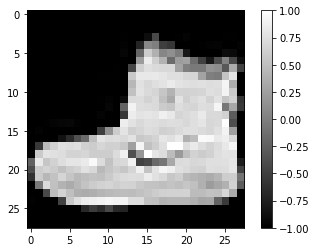

In [7]:
# 첫번째 이미지
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

- plt.colorbar()를 통해 각 픽셀의 값과 그에 따른 색을 확인했을 때, 정규화 과정을 거쳤기 때문에 -1이 가장 어두운 검은색, 1이 가장 밝은 흰색을 띤다

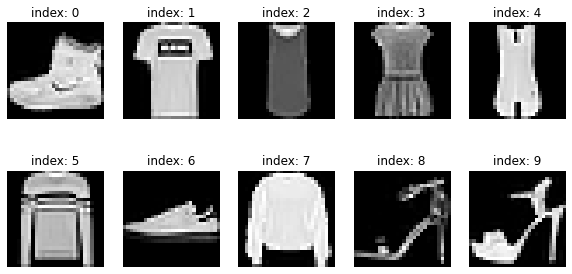

In [8]:
# for문을 이용해 10개 확인하기
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

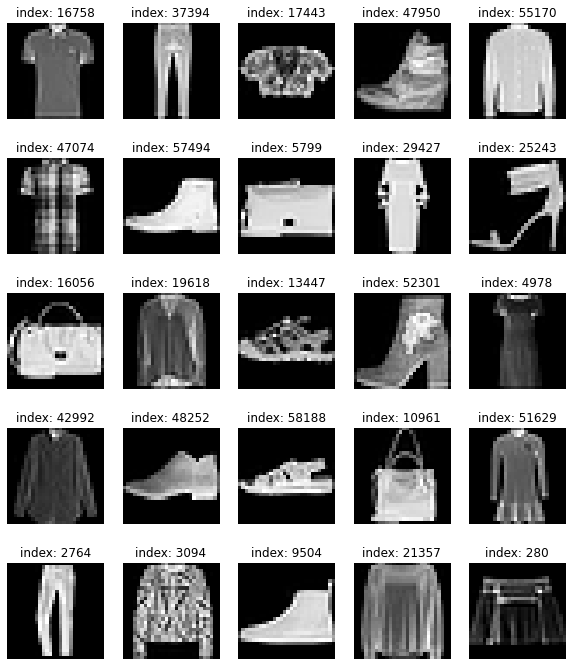

In [9]:
# 랜덤으로 25개 이미지 뽑기
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [10]:
# 학습 준비
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.  
- from_tensor_slices() 함수 : 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.  
- shuffle() 함수 : 데이터셋을 잘 섞어서 모델에 넣어준다.

## 11-9. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (2) 생성자 구현하기

In [11]:
# DCGAN(Deep Convolutional GAN) 구현하기(생성자 구현)
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- [Transposed convolution layer](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11) : 표준 컨볼루션 계층의 작업을 반대로 한다. 전치 컨볼루션은 표준 컨볼루션을 값으로 뒤집지 않고 치수로만 뒤집는다.
- Conv2DTranspose 레이어 : 이미지 사이즈를 넓혀주는 층(<-> Conv2D). (7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)  
- [BatchNormalization](https://eehoeskrap.tistory.com/430) 레이어 : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화(이곳저곳에 다쓰인다고 한다.)  
- LeakyReLU 활성화 함수 : 음의 영역에서 0.01을 곱해 ReLU의 단점을 보완  
- tanh 활성화 함수 : -1 ~ 1 이내의 값으로 픽셀 값을 정규화

- 입력 벡터 : (batch_size, 100(noise))  
- 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense layer를 거쳐 (batch_size, 12544) 형태의 벡터가 된다.  
- 다음으로 reshape layer(이후 layer에서 Convolution 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256)형상의 3차원 벡터로 변환시키는 작업)를 통과  
(noise와 7 x 7 사이즈는 임의로 설정한 것으로 계산의 편의를 위해 이렇게 설정하였다.)

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [13]:
# 랜덤 노이즈 벡터를 생성하여 결과물 만들기
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
 # 학습하는 중이 아니기 때문에 training=False로 설정(Batch Normalization 레이어는 훈련 시기와 추론 시기의 행동이 달라 제대로 설정해주어야 함)
generated_image.shape

TensorShape([1, 28, 28, 1])

- batch_size = 1인 (28, 28, 1)사이즈 이미지 생성

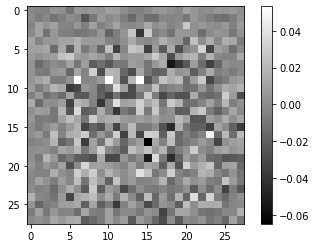

In [15]:
# 이미지 시각화
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

- matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (28, 28) shape의 이미지를 꺼낼 수 있도록 해주어야 한다.  
- -1과 1 사이의 값에서 적당히 잘 생성되었다. 아직 학습이 되지 않은 상태라 결과물이 이상하지만 모델을 점차 학습해 나가며 제대로 된 이미지를 생성하면 된다.

## 11-10. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (3) 판별자 구현하기

In [16]:
# 판별자 구현하기
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

- Conv2D 층으로 이미지의 크기를 점점 줄여나가기 : (28, 28, 1) → (14, 14, 64) → (7, 7, 128)
- Flatten 층 : 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환(<-> reshape layer)
- Dense Layer : 단 하나의 값을 출력

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00160949]], dtype=float32)>

- 텐서의 형태로 출력이 되었지만 아직 학습을 안한 상태이기 때문에 아무런 의미가 없는 값이다.

## 11-11. 생성 모델이 똑똑해지기 위한 기나긴 여정 (1) 손실함수와 최적화 함수
### 손실함수

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- tf.keras.losses 라이브러리 안에 있는 crossentropy 함수를 사용한다.  
- 판별자 모델의 마지막 layer에 값을 정규화하는 sigmoid나 tanh 등의 활성화 함수가 없기 때문에 from_logits=True로 설정해주었다. (BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정하기 때문에)

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)  
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [20]:
# fake_output과 real_output을 각각 1 또는 0에 비교하기(예시)
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

- tf.ones_like(), tf.zeros_like() 함수 : 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만든다.

In [21]:
# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- generator_loss는 fake_output가 1에 가까울수록(좋다) cross_entropy값은 작은 값을 가진다.

In [22]:
# discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator_loss는 real_output(기울기) 값은 1에 가까울수록, fake_output 값은 0에 가까울수록 좋다.
- real_output은 1로 채워진 벡터와, fake_outputdms 0으로 채워진 벡터와 비교.

In [23]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다고 좋은 것은 아니다. real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. 생성자도 잘 속이고, 판별자도 잘 구별해내는 것이 좋은 것이다.  
- (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별  
ex. eal_output = tf.Tensor([0.2, 0.4, 0.7, 0.9])일 때 -> tf.Tensor([False, False, True, True])  
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환  
ex. tf.Tensor([False, False, True, True]) -> tf.Tensor([0.0, 0.0, 1.0, 1.0])  
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산  
ex. tf.Tensor([0.0, 0.0, 1.0, 1.0]) -> 0.5

### 최적화 함수 - Adam

In [24]:
# 생성자와 구분자 따로 optimizer 만들어주기(따로따로 학습을 진행하는 개별 네트워크이기 때문)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
# 100차원의 노이즈를 총 16개 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.

## 11-12. 생성 모델이 똑똑해지기 위한 기나긴 여정 (2) 훈련과정 설계

In [26]:
# train step
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- @tf.function 이라는 데코레이터 붙여서 사용 : 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있다.  
- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
- (3) [tf.GradientTape()](https://rfriend.tistory.com/556)는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산  
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신 (trainable_variables : 상수를 다 제외하고 사용할 수 있는 값만 빼놓은 것)  
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

In [27]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.  
- 16개의 sampled을 시각화하는 과정과 비슷하다.  
- plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장한다.

In [28]:
# 시각화하는 함수 만들기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- gen_loss, disc_loss, real_accuracy, fake_accuracy 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수이다.  
- GAN 학습 과정은 지도학습 모델보다 까다롭다. 두 모델이 서로의 학습 과정에 영향을 주고받기 때문이다.

In [29]:
# 정기적으로 모델을 저장하기 위한 checkpoint 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 비상 상황을 대비하여 중간 중간 checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다.(생성자와 판별자가 학습한 모델 가중치를 저장한다.)

## 11-13. 생성 모델이 똑똑해지기 위한 기나긴 여정 (3) 학습 시키기

In [30]:
# 지금까지 만든 함수들 합치기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

- 지금까지 만든 함수들은 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint가 있다.

In [31]:
save_every = 5 # 저장 간격 담당
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

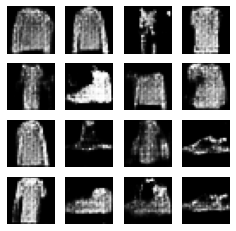

Time for training : 791 sec


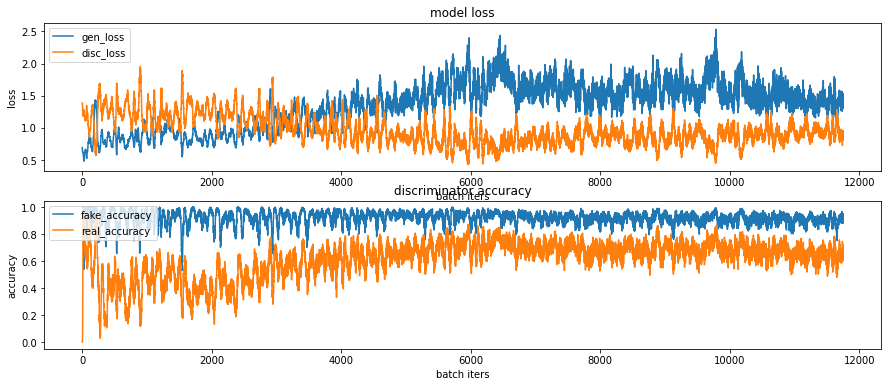

CPU times: user 6min 30s, sys: 1min 21s, total: 7min 52s
Wall time: 13min 12s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

- Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 것이다.  

In [33]:
# 학습 과정 시각화(학습 과정을 gif로 저장)
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1097458 Dec 18 11:56 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


- GIF 파일은 imageio 라이브러리를 활용한다. imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식.